Emily, AJ, &
Assignment 2
CSC 561 - Professor Alvarez
4/18/2025

In [13]:
pip install torch torchvision torchaudio


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [14]:
import torch
import torchvision
import matplotlib.pyplot as plt

print("PyTorch version:", torch.__version__)
print("TorchVision version:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())

# Optional: Check if you can run some basic tensor operations
a = torch.rand(2, 3)
print(a)


PyTorch version: 2.6.0+cu124
TorchVision version: 0.21.0+cu124
CUDA available: False
tensor([[0.5581, 0.6263, 0.5757],
        [0.7902, 0.5178, 0.0720]])


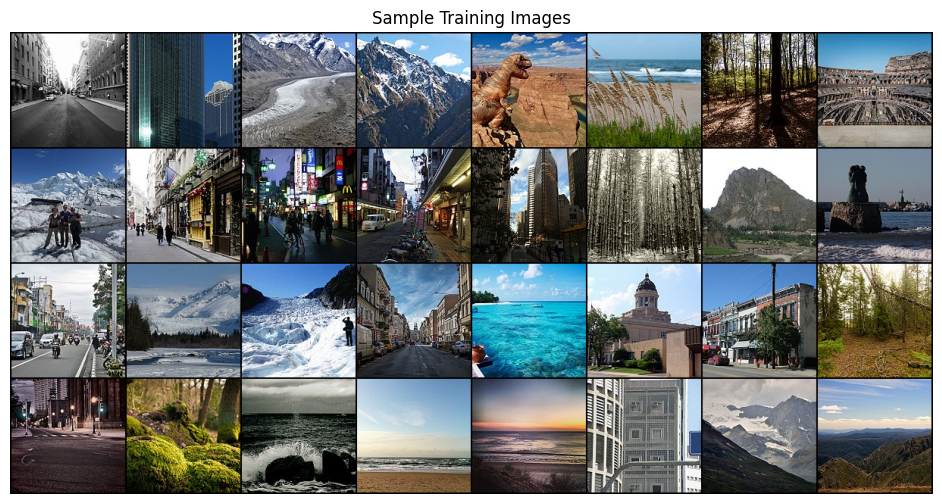

In [15]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Path to your dataset
data_path = "/work/pi_csc561_uri_edu/datasets/intel-images"
train_path = os.path.join(data_path, "training")

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize the images
    transforms.ToTensor(),          # Convert the images to tensor
])

# Load training dataset
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Display some sample images
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

images, labels = next(iter(train_loader))
plt.figure(figsize=(12, 6))
plt.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
plt.axis('off')
plt.title("Sample Training Images")
plt.show()


In [16]:
import torch.nn as nn
import torch.optim as optim

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 37 * 37, 512)  # Adjusted for input image size
        self.fc2 = nn.Linear(512, 6)  # 6 output classes

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = x.view(-1, 64 * 37 * 37)  # Flatten
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
model = SimpleCNN()

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [20]:
# Train the model
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    print(f"Start epoch {epoch + 1}")
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

# Save the trained model
torch.save(model.state_dict(), "intel_cnn_model.pth")

Start epoch 1
Epoch 1/10, Loss: 0.6229923173343945
Start epoch 2
Epoch 2/10, Loss: 0.39589744064625954
Start epoch 3
Epoch 3/10, Loss: 0.1979831973841766
Start epoch 4
Epoch 4/10, Loss: 0.08621534349445618
Start epoch 5
Epoch 5/10, Loss: 0.0543925671460073
Start epoch 6
Epoch 6/10, Loss: 0.037115456237285856
Start epoch 7
Epoch 7/10, Loss: 0.04817611267390435
Start epoch 8
Epoch 8/10, Loss: 0.02813353884458947
Start epoch 9
Epoch 9/10, Loss: 0.014223022603832004
Start epoch 10
Epoch 10/10, Loss: 0.015115719582708628


In [ ]:
# Load test dataset (without labels)
test_path = os.path.join(data_path, "test")
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Prediction on the test dataset
model.eval()
predictions = []

with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# Save the predictions to the required file
image_ids = [f"image_{i+1}.jpg" for i in range(len(predictions))]

with open("cnn-predictions.txt", "w") as f:
    for image_id, label in zip(image_ids, predictions):
        f.write(f"{image_id} {label}\n")
